In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import scipy.optimize as stats2
import statsmodels.api as sm
from statsmodels.formula.api import ols
import random
import inspect
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
from dmba import stepwise_selection,AIC_score
from statsmodels.stats.outliers_influence import OLSInfluence
warnings.filterwarnings('ignore')


In [168]:
df_prueba = pd.DataFrame({
"ES_NO_ES":[np.random.choice(['s','n']) for _ in range(1000)],
"sexo":[np.random.choice(['h','m']) for _ in range(1000)],
"Datos_C":[np.random.choice([0,1]) for _ in range(1000)],
"Datos_D": list(np.random.standard_normal(1000)),
"Datos_E": list(np.random.standard_normal(1000)),
"Datos_Poisson_1": list( stats.poisson.rvs(mu=4, size=1000)),
"Datos_Poisson_3": list( np.random.poisson(lam=10, size=1000)),
"Datos_Geom": list( stats.geom.rvs(0.75, size=1000)),
"Datos_F": [np.random.randint(0,1000) for _ in range(1000)],
"Datos_G": [np.random.randint(0,1000) for _ in range(1000)],
"Datos_cate_A": ['Grupo '+str(np.random.randint(0,6)) for _ in range(1000)],
"Datos_cate_B": ['Grupo '+str(np.random.randint(0,4)) for _ in range(1000)],
"Datos_cate_C": [np.random.randint(0,60) for _ in range(1000)],

})

for i in range(1,6):
    df_prueba['Datos_E'][random.randint(0,23)]=None


for i in range(1,10):
    df_prueba['Datos_F'][random.randint(0,23)]=None

for i in range(0,11):
    df_prueba['Datos_G'][i]=None


In [169]:

class DF_exploracion(pd.DataFrame):

    def __init__(self, *args, **kw):
        super(DF_exploracion, self).__init__(*args, **kw)
        self.cuanti=pd.DataFrame
        self.cuanti_antes_de_outliers_y_inputs=pd.DataFrame
        self.cuali=pd.DataFrame
        self.dico=pd.DataFrame
        self.cate=pd.DataFrame
        self.eliminado=pd.DataFrame
        self.dummy=pd.DataFrame
        self.df=pd.DataFrame
        self.df_inputado=pd.DataFrame
        self.df_limpio=pd.DataFrame
        self.predicotres=pd.DataFrame
        self.outcome=pd.DataFrame
        self.normal_cuatis=[]
        self.normal_grupos_dico=[]
        self.normal_grupos_cate=[]
        self.discreta=[]
        self.stingg=[]
        self.outliers_hecho=True
        self.porcentaje_nulos_permitido=0.3

    def variables(self):

        dico=[]
        cuantis=[]
        categori=[]
        eliminar=[]
        

        for i in self.columns: 

            try:
                datos=self[i].dropna().to_numpy()
                discreta=True
                for j in datos:
                    if (j%1 !=0):
                        discreta=False
                        break
                    else:
                        continue
                if (discreta):
                    self.discreta.append(i)
            except:
                self.stingg.append(i)

            nulos= (self[i].isnull().sum())/len(self[i])
            
            if ((len(self[i].dropna().unique())==2) and (nulos<=self.porcentaje_nulos_permitido)):
                tipo_de_var=f"{len(self[i].dropna().unique())} tipos, posiblemente: DICOTOMICA"
                dico.append(i)

            elif ((len(self[i].dropna().unique())>10) and  (nulos<=self.porcentaje_nulos_permitido)):
                tipo_de_var=f"{len(self[i].dropna().unique())} tipos, posiblemente: CUANTITATIVA"
                cuantis.append(i)

            elif ( (len(self[i].dropna().unique())<2) or (nulos>self.porcentaje_nulos_permitido)):
                tipo_de_var=f"SOLO {len(self[i].dropna().unique())} TIPOS, NO VALE LA COLUMNA"
                eliminar.append(i)
            else:
                tipo_de_var=f"{len(self[i].dropna().unique())} tipos, posiblemente: CATEGORICA/CUANTI"
                categori.append(i)

            print (f"|  {i} \n|   - Tipo de dato: {self[i].dtype} \n|   - Valores repetidos: {tipo_de_var} \n|   - Nulos: {nulos} \n| ")

        print (f"|----------------------------------------------------------------------------------------------------\n|  TODAS: {self.columns} \n|  DICOTOMICAS: {dico} \n|  CATEGORICAS: {categori} \n|  CUANTITATIVAS: {cuantis} \n|  ELIMINAR: {eliminar}")
        print("|----------------------------------------------------------------------------------------------------")

        


        self.DF_cuantis(cuantis)
        self.DF_cualis(categori+dico)
        self.DF_dicotomica(dico)
        self.DF_categorica(categori)
        self.DF_elimiminado(eliminar)
        self.df=self
        
    def todas_col(self):
        return self.df
    
    def DF_cuantis(self,lista):
        self.cuanti=self[lista]

    def DF_elimiminado(self,lista):
        self.eliminado=self[lista]
        
    def DF_cualis(self,lista):
        self.cuali=self[lista]
        
    def DF_dicotomica(self, lista):
        self.dico=self[lista]
        
    def DF_categorica(self, lista):
        self.cate=self[lista]   



    def limpiar_aux(self):
        
        try:
            df_nuevo=pd.DataFrame
            aux1=list(self.dico.columns)
            aux=[]
            df_nuevo=pd.get_dummies(self.df, columns=aux1)
            
            for columna in df_nuevo.columns:
                for variables in list(self.dico.columns):
                    if variables in columna:
                        aux.append(columna)
                    
            self.dummy=df_nuevo[aux]
            self[aux]=df_nuevo[aux]

            # self.df=self.drop(columns=var, axis='columns')
            # self.df= self[self.columns.difference(self.dico.columns)]
            
            print("********************** self.dummy ************\n")
            print(self.dummy)
            print("\n********************** self.df o todas_las_col() ************\n")
            print(self.df)

        except:
            print("---------------------- ERROR -----------------")



    def limpiar_dummys(self):

        b=False
        lista=list(self.dico.columns)
        for ind, i in enumerate(lista):
                if (ind+1<len(lista)):
                    if( (i in lista [ind+1]) ):
                        b=True
                        break
        if b:
            nombres_nuevos=[]
            if len(lista)>2:
                for ind, i in enumerate(lista):
                    if (ind+1<len(lista)):
                        if( (i in lista [ind+1]) ):
                            nombres_nuevos.append(i.upper())
                        else:
                            nombres_nuevos.append(i)
                    else:
                        nombres_nuevos.append(i)
                        
            aux_df=self.df

            for i,j in zip(lista,nombres_nuevos):
                aux_df.rename(columns={i:j},inplace=True)
                
            self.df=aux_df
            self.dico.columns=nombres_nuevos
            
            self.limpiar_aux()
        else: 
            self.limpiar_aux()



    def estadistica_descriptiva_cuantis(self):

        print("----------------------------------------------------------------------------------------------------\nDESCRIPCIÓN")
        print (self.cuanti.describe())
        print("\n")
        print("----------------------------------------------------------------------------------------------------\nCUARTILES")
        print (self.cuanti.quantile([0.05,0.25,0.5,0.75,0.95]))
        print("\n")
        print("----------------------------------------------------------------------------------------------------\n")
        print("\n")
        print("----------------------------------------------------------------------------------------------------\n")


        aux1=self.dico.columns
        aux2=self.cate.columns
        aux=self.cuanti.columns

        # df_auxiliar = self.groupby('sexo').apply(lambda x: pd.Series(shapiro(x), index=['W','P'])).reset_index()
        # print(df_auxiliar)
                
        for a in list(aux1.values):
            
            for b in list(aux.values):
                
                print("++++++++++++++++++++++++++++  "+a+" y "+b+"  ++++++++++++++++++++++++++\n")
                agrupado=self.groupby(a)[b]
                titulo=f"Agrupado por {a} y por {b}"
                print(titulo)
                print(agrupado.describe().reset_index())
                # df.groupby(['cat1', 'cat2'])['purchases','sales'].apply(stats.shapiro)
                print("////////////////////////// TEST DE SHAPIRO ////////////////////////////")
                aux_shapiro=(agrupado.apply(stats.shapiro))
                print(aux_shapiro)
        
                
                print("\n")
                print("----------------------------------------------------------------------------------------------------\n")


    def estadistica_descriptiva_cualis(self):

        print("\n--------------------- Variables dico ---------------------")
        print("\n")
        for i in self.dico.columns:
            print(f"...........Frecuencia variable {i} ....................")
            print(self[i].value_counts()/(self[i].count()))
            print("\n")

        print("\n-------------------- Variables categoricas --------------------")
        print("\n")
        for i in self.cate.columns:
            print(f"...........Frecuencia variable {i} ....................")
            print(self[i].value_counts()/(self[i].count()))
            print("\n")
        print("\n\n")

        # crosstab variables cualis con cate
        aux=list(self.cate.columns)

        a=0
        for i in aux:
            a=a+1
            if a<len(aux)/2:
                b=0
                for j in aux[:-1]:
                    b=b+1
                    if b > a:
                        print(f"*************** TABAL DE VARIABLES CATEGORICAS {i} y {j} *********************\n ")
                        tab = pd.crosstab (index=self[i], columns=self[j])
                        x=(tab/tab.sum())
                        print(tab)
                        print("\n")
                        print(f"/////////////////// EN PROPORCION //////////////////\n")
                        print(x)
                        print("\n\n")


    def anova(self):

        aux_cate=list(self.cate.columns)
        aux_cuati=list(self.cuanti.columns)

        for i in aux_cate:
            for j in aux_cuati:
                try:
                    print(f"\n----------- ANOVA Categoria {i} y variable continua {j} ----------\n")
                    model = ols(f"{j} ~ {i}", data=self).fit()
                    a=sm.stats.anova_lm(model, typ=2)
                    print(a)
                except:
                    print(f"\n - - - - - Fallo en variable {i} y {j} - - - - - - \n")
                    continue




    def Chi(self):

        aux_dico=list(self.dico.columns)

        if len(aux_dico)>1:
            for ind, i in enumerate(aux_dico):
                for j in range(ind+1,len(aux_dico)):
                    chi, p, dof, expected = stats.chi2_contingency(pd.crosstab(self[i],self[aux_dico[j]]), correction=False)
                    print(f"\n-------------- Chi2 entre {i} y {aux_dico[j]} ----------------")
                    print(f"p: {p} \n") 
        else:
            print("******************** No suficientes argumentos ********************")


    def t_test_aux(self, columns):
        results = []
        for i, col1 in enumerate(columns[:-1]):
            for col2 in columns[i+1:]:
                t, p = stats.ttest_ind(self[col1].dropna(), self[col2].dropna(), equal_var=False)
                # results.append((col1, col2, t, p))
                if p < 0.05:
                    print( f"+++++ Variable{col1}, variable 2 {col2} con p de: \033[1m{p}\033[0m  Se RECHAZA H0 ++++") 
                else:
                    print( f"+++++ Variable{col1}, variable 2 {col2}  con p de: {p} SE ACEPTA H0 ++++") 
    
    def wilcoxon_test_aux(self,col1, col2):
        if (col1== col2).all():
            print ("\nLas coluimnas son iguales\n")
        res = stats.wilcoxon(col1, col2)
        if res.pvalue < 0.05:
            print(f"Reject null hypothesis. Significant difference  (p-value={res.pvalue:.4f})")
        else:
            print (f"Fail to reject null hypothesis. No significant difference (p-value={res.pvalue:.4f})")

    def wilconxon(self, lista):
        # lista=[grupo, var]
        a,b=self.agrupar(lista)
        print(f"\n- Variable: {lista[1]}, Grupo: {lista[0]}")
        self.wilcoxon_test_aux(a, b)

    def agrupar (self, lista):
        groupby_col=lista[0]
        col=lista[1]
        valor=self[groupby_col].unique()
        group= self.where(self[groupby_col]== valor[0])[col]
        group2= self.where(self[groupby_col]== valor[1])[col] 
        return group,group2

    # def t_test_groupby_one_col(self, col, groupby_col):
        
    #     group= self.where(self[groupby_col]== self[groupby_col][0]).dropna()[col]
    #     group2= self.where(self[groupby_col]== self[groupby_col][1]).dropna()[col]
    #     t, p = stats.ttest_ind(group, group2, equal_var=False)
    #     print( col, groupby_col,p) 

    def t_test_all(self):
        aux=list(self.cuanti.columns)
        aux2=list(self.dico.columns)
        self.t_test_aux(self.normal_cuatis) #aqui ya hace todas las cuantis entre ellas faltan los grupos
        for i in self.normal_grupos_dico:
            a,b=self.agrupar(i)
            t, p = stats.ttest_ind(a.dropna(), b.dropna(), equal_var=False)
            if p < 0.05:
                print( f"+++++ Variable{i[1]}, Agrupado por {i[0]} con p de: \033[1m{p}\033[0m  Se RECHAZA H0 ++++") 
            else:
                print( f"+++++ Variable{i[1]}, Agrupado por {i[0]} con p de: {p} SE ACEPTA H0 ++++") 
    # df_prueba.groupby('sexo').apply(lambda df: stats.ttest_ind(df['Datos_D'].dropna(), df['Datos_E'].dropna())[1])


    def plot_confidence_interval(self, col, confidence_level= 0.95):
        data = self[col].to_numpy()
        n = len(data)
        mean =self[col].mean(axis=0)
        # std_error = stats.sem( self[col].dropna())
        std_error = self[col].dropna().std()
        lower_bound = stats.t.ppf(0.025, n - 1, loc = mean, scale = std_error)  # =>  99.23452406698323
        upper_bound = stats.t.ppf(0.975, n - 1, loc = mean, scale = std_error)
        # h = std_error * stats.t.ppf((1 + confidence_level) / 2, n - 1)
        
        # lower_bound = mean - h
        # upper_bound = mean + h
        # plt.hist(data, bins=30, edgecolor='black', alpha=0.5)
        # plt.axvspan(lower_bound, upper_bound, color='gray', alpha=0.2, label=f'{confidence_level * 100}% Confidence Interval')
        # plt.axvline(x=mean, color='red', label='Sample Mean')
        # plt.legend()

        fig, ax = plt.subplots()
        ax.hist(data, bins=30, edgecolor='black', alpha=0.5)
        ax.axvline(x=mean, color='red', label='Sample Mean')
        ax.axvspan(lower_bound, upper_bound, color='grey', alpha=0.5, label=f'{confidence_level * 100}% Confidence Interval')
        ax.annotate(
            f'lower_bound:\n {lower_bound:.2f}',
            xy=(lower_bound, 0), xytext=(lower_bound-0.5, 50)
        )
        ax.annotate(
            f'upper_bound:\n  {upper_bound:.2f}',
            xy=(upper_bound, 0), xytext=(upper_bound-0.5, 50)
        )
        ax.legend()
        
        plt.show()


    def plot_normailidad(self):
        aux=self.cuanti.columns
        for i in aux:
            stats.probplot(self[i], dist="norm", plot=plt)
            plt.title("Probability Plot - " )
            plt.show()
    


    def plot_bigotes(self):

        aux1=self.dico.columns
        aux2=self.cate.columns
        aux=self.cuanti.columns
        print("\n+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")

        print("-------------- Graficas de bigotes cualitativas-------------------")
        # fig = plt.figure(figsize=(12, 8))
        
        (self.cuanti).plot(kind='box', title='Variables cuantitativas',figsize=(12, 8))
        plt.show()
        

        print("-------------- Graficas de bigotes por dicotomicas-------------------")   
        
        for a in aux1:

            # fig = plt.figure(figsize=(12, 8))
            self.boxplot(column=list(aux.values), by=a,figsize=(12, 8))
            plt.tight_layout() 
            plt.show()
        
        print("\n")
        print("----------------------------------------------------------------------------------------------------\n")
        
        print("-------------- Graficas de bigotes por categoricas-------------------") 

        for a in aux2:
            # fig = plt.figure(figsize=(12, 8))
            ax= self.boxplot(column=list(aux.values), by=a, figsize=(12, 8))
            # ax = sns.swarmplot(column=list(aux.values), by=a,data=self, color='#7d0013')
            plt.tight_layout() 
            plt.show()
        print("\n")
        print("----------------------------------------------------------------------------------------------------\n")

        
        print("\n+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")



    def plot_corr(self):

        print("\n+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")
        print("----------------------------------------------------------------------------------------------------\n")
        
        print("-------------- MATRIZ DE CORRELACIONES ENTRE CUANTITATIVAS -------------------\n") 

        fig = plt.figure(figsize=(12, 8))
        matrix = self.cuanti.corr().round(2)
        mask = np.triu(np.ones_like(matrix, dtype=bool))
        sns.heatmap(matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', mask=mask)  
        plt.show()

        print("----------------------------------------------------------------------------------------------------\n")

        print("\n+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")


    def plot_barras(self):
        aux=self.cuanti.columns

        print("\n+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")
        print("----------------------------------------------------------------------------------------------------\n")

        print("-------------- GRAFICA DE BARRAS DE TODAS LAS CUANTITATIVAS -------------------\n") 
        # fig = plt.figure(figsize=(15, 20))
        self.cuanti.plot.bar(figsize=(18, 8))
        plt.show()

        print("-------------- GRAFICA DE BARRAS CON DISTRIBUCIÓN DE DENSIDAD DE CADA CUANTITATIVA  -------------------\n") 
        for i in list(aux.values):
            fig = plt.figure(figsize=(12, 8))
            print(f"\n.............. GRAFICA DE BARRAS  DE {i} ............\n") 
            ax=self[i].plot.hist(density=True)
            self[i].plot.density(ax=ax)
            plt.show()

        print("----------------------------------------------------------------------------------------------------\n")    
        print("\n+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")


    def todos_plots(self):

        self.plot_bigotes()
        self.plot_corr()
        self.plot_barras()
        self.violines()
        
        

    def violines(self):

        aux1=self.dico.columns
        aux2=self.cate.columns
        aux=self.cuanti.columns

        print("--------------  GRAFICA DE VIOLINES  -------------------\n") 
        sns.set(style="whitegrid")
        for i in aux2:
            for j in aux:
                ax= sns.violinplot(x=self[i], y=self[j], palette="Set2", split=True, inner="quartile",scale="count")
                plt.show()

        print("\n\n/////////-------------- GRAFICA DE VIOLINES POR DICOTOMICAS -------------------/////////////\n") 
        
        for i in aux2:
            for j in aux:
                for k in aux1:
                    ax= sns.violinplot(x=self[i], y=self[j], hue=self[k],palette="Set2", split=True, inner="quartile",scale="count")
                    plt.show()


    def cross_var_cualis_con_ciantis(self):

        aux=list(self.cate.columns)
        aux_cuati=list(self.cuanti.columns)

        for k in aux_cuati:
            a=0
            for i in aux:
                a=a+1
                if a<len(aux)/2:
                    b=0
                    for j in aux[:-1]:
                        b=b+1
                        if b > a:
                            print(f"\n\n*************** TABAL DE VARIABLES CATEGORICAS {i} y {j} con valores de {k} MEDIA *********************\n ")
                            tab = pd.crosstab (index=self[i], columns=self[j],values=self[k],aggfunc=np.mean)
                            print(tab)
                            print("\n\n")

    def nulos(self):
        aux_df=list(self.cuanti.columns)
        self.inputado=self.df
        for i in aux_df:
            nulos=self[i].isna().sum()
            total=len(self[i])
            porcentaje=nulos/total
            if ((nulos>0)):
                percen=self[i].quantile([0.2,0.8]).to_list()
                self[i]=self[i].apply(lambda x: ( random.randint ( round(percen[0]) , round(percen[1]) )) if pd.isna(x) else x )
                print(f"\n- Se han inputado {nulos} nulos a la variable {i} (tenía porcentaje de nulos de: {porcentaje}) \n")
            elif (porcentaje>self.porcentaje_nulos_permitido):
                print(f"\n - No se ha podido inputar a la variable {i} porque el porcentaje de nulos era de {porcentaje}\n")
                

    def normalidad(self):
        
        DataF=self.df
        aux1=self.dico.columns
        aux2=self.cate.columns
        aux=self.cuanti.columns
                
        for b in list(aux.values):
            aux_shapiro=(stats.shapiro(DataF[b]))
            if(aux_shapiro.pvalue<0.05):
                print("////////////////////////// TEST DE SHAPIRO CUANTITATIVAS ////////////////////////////")
                print("++++++++++++++++++++++++++++  "+ b +"  ++++++++++++++++++++++++++\n")
                titulo=f"Variable cuantitativa {b} y test Shapiro < 0.05"
                print(titulo)
                print(aux_shapiro)
                print("\n")
                print("----------------------------------------------------------------------------------------------------\n")
                self.normal_cuatis.append(b)

        for a in list(aux1.values):
            for b in list(aux.values):
                    agrupado=DataF.groupby(a)[b]
                    try:
                        aux_shapiro=(agrupado.apply(stats.shapiro))
                        for h in aux_shapiro:
                            if(h.pvalue<0.05):
                                print("////////////////////////// TEST DE SHAPIRO DICOTOMICAS ////////////////////////////")
                                print("++++++++++++++++++++++++++++  "+a+" y "+b+"  ++++++++++++++++++++++++++\n")
                                titulo=f"Agrupado por {a} y por {b} y test Shapiro < 0.05"
                                print(titulo)
                                print(aux_shapiro)
                                print("\n")
                                print("----------------------------------------------------------------------------------------------------\n")
                                self.normal_grupos_dico.append([a,b])
                    except:
                        continue 

        for a in list(aux2.values):
            for b in list(aux.values):
                    agrupado=DataF.groupby([a])[b]
                    try:
                        aux_shapiro=(agrupado.apply(stats.shapiro))
                        for h in aux_shapiro:
                            if(h.pvalue<0.05):
                                print("////////////////////////// TEST DE SHAPIRO CATEGORICAS ////////////////////////////")
                                print("++++++++++++++++++++++++++++  "+a+" y "+b+"  ++++++++++++++++++++++++++\n")
                                titulo=f"Agrupado por {a} y por {b} y test Shapiro < 0.05"
                                print(titulo)
                                print(h)
                                print("\n")
                                print("----------------------------------------------------------------------------------------------------\n")
                                self.normal_grupos_cate.append([a,b])
                    except:
                        continue 

        self.normal_grupos_dico=[i for n, i in enumerate(self.normal_grupos_dico) if i not in self.normal_grupos_dico[:n]]
        self.normal_grupos_cate=[i for n, i in enumerate(self.normal_grupos_cate) if i not in self.normal_grupos_cate[:n]]
        
    def detec_outlaiers(self):
        aux=list(self.cuanti.columns)
        aux_DF=self.cuanti
        for i in aux:
            z = np.abs(stats.zscore(aux_DF[i]))
            print(z)
    
    def seleccionar_distribuciones(self,familia='realall', verbose=False):
        '''
        Parameters
        ----------
        familia : {'realall', 'realline', 'realplus', 'real0to1', 'discreta'}
            realall: distribuciones de la familia `realline` + `realplus`
            realline: distribuciones continuas en el dominio (-inf, +inf)
            realplus: distribuciones continuas en el dominio [0, +inf)
            real0to1: distribuciones continuas en el dominio [0,1]
            discreta: distribuciones discretas
            
        verbose : bool
            Si se muestra información de las distribuciones seleccionadas
            (the default `False`)
        '''
    
        distribuciones = [getattr(stats,d) for d in dir(stats) \
                        if isinstance(getattr(stats,d), (stats.rv_continuous, stats.rv_discrete))]
        
        exclusiones = ['levy_stable', 'vonmises']
        distribuciones = [dist for dist in distribuciones if dist.name not in exclusiones]
                
        dominios = {
            'realall' : [-np.inf, np.inf],
            'realline': [np.inf,np.inf],
            'realplus': [0, np.inf],
            'real0to1': [0, 1], 
            'discreta': [None, None],
        }

        distribucion = []
        tipo = []
        dominio_inf = []
        dominio_sup = []

        for dist in distribuciones:
            distribucion.append(dist.name)
            tipo.append(np.where(isinstance(dist, stats.rv_continuous), 'continua', 'discreta'))
            dominio_inf.append(dist.a)
            dominio_sup.append(dist.b)
        
        info_distribuciones = pd.DataFrame({
                                'distribucion': distribucion,
                                'tipo': tipo,
                                'dominio_inf': dominio_inf,
                                'dominio_sup': dominio_sup
                            })

        info_distribuciones = info_distribuciones \
                            .sort_values(by=['dominio_inf', 'dominio_sup'])\
                            .reset_index(drop=True)
        
        if familia in ['realall', 'realline', 'realplus', 'real0to1']:
            info_distribuciones = info_distribuciones[info_distribuciones['tipo']=='continua']
            condicion = (info_distribuciones['dominio_inf'] == dominios[familia][0]) & \
                        (info_distribuciones['dominio_sup'] == dominios[familia][1]) 
            info_distribuciones = info_distribuciones[condicion].reset_index(drop=True)
            
        if familia in ['discreta']:
            info_distribuciones = info_distribuciones[info_distribuciones['tipo']=='discreta']
            
        seleccion = [dist for dist in distribuciones \
                    if dist.name in info_distribuciones['distribucion'].values]
        
        
        if verbose:
            print("---------------------------------------------------")
            print("       Distribuciones seleccionadas                ")
            print("---------------------------------------------------")
            with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
                print(info_distribuciones)
        
        return seleccion


    def plot_multiple_distribuciones(self, nombre_distribuciones):

        aux=list(self.cuanti.columns)
        fig, ax = plt.subplots(figsize=(15,15))

        for i in aux:
            x=self[i]
            if ax is None:
                fig, ax = plt.subplots(figsize=(7,4))
                
            ax.hist(x=x, density=True, bins=30, color="#3182bd", alpha=0.5)
            ax.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
            ax.set_title('Ajuste distribuciones')
            ax.set_xlabel('x')
            ax.set_ylabel('Densidad de probabilidad')
            
            for nombre in nombre_distribuciones:
                
                distribucion = getattr(stats, nombre)

                parametros = distribucion.fit(data=x)

                nombre_parametros = [p for p in inspect.signature(distribucion._pdf).parameters \
                                    if not p=='x'] + ["loc","scale"]
                parametros_dict = dict(zip(nombre_parametros, parametros))

                log_likelihood = distribucion.logpdf(x, *parametros).sum()

                aic = -2 * log_likelihood + 2 * len(parametros)
                bic = -2 * log_likelihood + np.log(x.shape[0]) * len(parametros)

                x_hat = np.linspace(min(x), max(x), num=100)
                y_hat = distribucion.pdf(x_hat, *parametros)
                ax.plot(x_hat, y_hat, linewidth=2, label=distribucion.name)
            
            ax.legend()
            plt.show()
        


    def fit_discrete(self,datos):

        # self.discreta

        mean = datos.mean()
        var = datos.var()
        likelihoods = {}  
        log_likelihoods = {}

        p = 1 - mean / var  
        r = (1-p) * mean / p



        log_likelihoods['nbinom'] = datos.map(lambda val: stats.nbinom.logpmf(val, r, p)).sum()

        lambda_ = mean

        log_likelihoods['poisson'] = datos.map(lambda val: stats.poisson.logpmf(val, lambda_)).sum()


        best_fit = max(log_likelihoods, key=lambda x: log_likelihoods[x])
        print("**** Best fit between poisson and nbinorm :", best_fit)
        

    
        plt.hist(datos, bins=int(np.max(datos)), density=True, alpha=0.5)

        mean = datos.mean()
        var = datos.var()


        def loss_function_poisson(params, datos_in):

            mu = params[0]

            loss = 0

            for i in range(len(datos_in)):

                loglikelihood = stats.poisson.logpmf(datos_in[i], mu)

                loss_to_add = -loglikelihood

                loss += loss_to_add

            return(loss)




        params0 = np.array([20])
        minimum = stats2.optimize.fmin(loss_function_poisson, params0, args=(datos,))

        mu_fit = minimum[0]

        print("***********  The best mu_fit is:  ",  mu_fit)
        print("\n")

        x = list(range(int(np.min(datos)), int(np.max(datos))+1))
        plt.scatter(x, stats.poisson.pmf(x, mu_fit),color="red")
        plt.show()   

        print("\n\n Otras variables discretas:  ",  self.discreta)


    def comparar_distribuciones_caunti_cont(self, ordenar='aic', verbose=False):

            '''
            resultados: data.frame
                distribucion: nombre de la distribución.
                log_likelihood: logaritmo del likelihood del ajuste.
                aic: métrica AIC.
                bic: métrica BIC.
                n_parametros: número de parámetros de la distribución de la distribución.
                parametros: parámetros del tras el ajuste
                
            Raises
            ------
            Exception
                Si `familia` es distinto de 'realall', 'realline', 'realplus', 'real0to1',
                o 'discreta'.
                
            Notes
            -----
            '''
            aux=list(self.cuanti.columns)
            
            for i in aux:
                print(f"\n ******************** Variable: {i} ******************** \n")
                x=self[i]
                distribuciones = self.seleccionar_distribuciones(familia='realall',verbose=verbose)
                distribucion_ = []
                log_likelihood_= []
                aic_ = []
                bic_ = []
                n_parametros_ = []
                parametros_ = []
                
                for j, distribucion in enumerate(distribuciones):
                    
                    # print(f"{j+1}/{len(distribuciones)} Ajustando distribución: {distribucion.name}")
                    
                    try:
                        parametros = distribucion.fit(data=x)
                        nombre_parametros = [p for p in inspect.signature(distribucion._pdf).parameters \
                                            if not p=='x'] + ["loc","scale"]
                        parametros_dict = dict(zip(nombre_parametros, parametros))
                        log_likelihood = distribucion.logpdf(x, *parametros).sum()
                        aic = -2 * log_likelihood + 2 * len(parametros)
                        bic = -2 * log_likelihood + np.log(x.shape[0]) * len(parametros)
                        
                        distribucion_.append(distribucion.name)
                        log_likelihood_.append(log_likelihood)
                        aic_.append(aic)
                        bic_.append(bic)
                        n_parametros_.append(len(parametros))
                        parametros_.append(parametros_dict)
                        
                        resultados = pd.DataFrame({
                                        'distribucion': distribucion_,
                                        'log_likelihood': log_likelihood_,
                                        'aic': aic_,
                                        'bic': bic_,
                                        'n_parametros': n_parametros_,
                                        'parametros': parametros_,
                            
                                    })
                        
                        resultados = resultados.sort_values(by=ordenar).reset_index(drop=True)

                        
                        
                    except Exception as e:
                        print(f"Error al tratar de ajustar la distribución {distribucion.name}")
                        print(e)
                        print("")

                nombre_distribuciones=resultados['distribucion'][:5]
                fig, ax = plt.subplots(figsize=(7,4))
                
                
                ax.hist(x=x, density=True, bins=30, color="#3182bd", alpha=0.5)
                ax.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
                ax.set_title('Ajuste distribuciones')
                ax.set_xlabel('x')
                ax.set_ylabel('Densidad de probabilidad')
                
                for nombre in nombre_distribuciones:
                    
                    distribucion = getattr(stats, nombre)

                    parametros = distribucion.fit(data=x)

                    nombre_parametros = [p for p in inspect.signature(distribucion._pdf).parameters \
                                        if not p=='x'] + ["loc","scale"]
                    parametros_dict = dict(zip(nombre_parametros, parametros))

                    log_likelihood = distribucion.logpdf(x, *parametros).sum()

                    aic = -2 * log_likelihood + 2 * len(parametros)
                    bic = -2 * log_likelihood + np.log(x.shape[0]) * len(parametros)

                    x_hat = np.linspace(min(x), max(x), num=100)
                    y_hat = distribucion.pdf(x_hat, *parametros)
                    ax.plot(x_hat, y_hat, linewidth=2, label=distribucion.name)
            
                ax.legend()
                plt.show()

                print("\n")
                print(resultados.head(5))    
                print("\n------------------------------------------------------------------\n")

    def remove_outliers(self, k=1.5):
        aux=list(self.cuanti.columns)
        for column in aux:
            print(f"\n\n                    <<<<<<<<<<<<<<<<<<<<<<<< {column} >>>>>>>>>>>>>>>>>>>>>>>>\n\n")
            self.plot_outliers2(column, k=1.5)
            q1, q3 = self[column].quantile([0.25, 0.75])
            iqr = q3 - q1
            lower_bound = q1 - (k * iqr)
            upper_bound = q3 + (k * iqr)
            self.loc[(self[column] < lower_bound) | (self[column] > upper_bound), column] = None    
        self.nulos()
        self.outliers_hecho=False


    def plot_outliers(self, column, k=1.5):
        
        q1, q3 = self[column].quantile([0.25, 0.75])
        iqr = q3 - q1
        lower_bound = q1 - (k * iqr)
        upper_bound = q3 + (k * iqr)
        
        fig, ax = plt.subplots()
        ax.scatter(self.index, self[column], color='blue', label='inlier')
        ax.scatter(self[(self[column] < lower_bound) | (self[column] > upper_bound)].index,
                self[(self[column] < lower_bound) | (self[column] > upper_bound)][column],
                color='red', label='outlier')
        ax.axhline(lower_bound, color='gray', linestyle='--')
        ax.axhline(upper_bound, color='gray', linestyle='--')
        plt.legend()
        plt.show() 

    
    def plot_outliers2(df, column, k=1.5):
        q1, q3 = df[column].quantile([0.25, 0.75])
        iqr = q3 - q1
        lower_bound = q1 - (k * iqr)
        upper_bound = q3 + (k * iqr)
        
        fig, ax = plt.subplots()
        ax.plot(df.index, df[column], color='blue')
        ax.scatter(df[df[column].isnull()].index,
                df[df[column].isnull()][column],
                color='red', marker='x')
        ax.axhline(lower_bound, color='red', linestyle='--')
        ax.axhline(upper_bound, color='red', linestyle='--')
        plt.show()
        
    def plot_xy_data(df, x_column, y_column):
        fig, ax = plt.subplots()
        ax.scatter(df[x_column], df[y_column])
        plt.xlabel(x_column)
        plt.ylabel(y_column)
        plt.show()


    def reg_lineal(self, predictores, OUTCOME):
        aux1=set(predictores)
        aux2=set(list(self.cuali.columns))
        self.predicotres=self[predictores]
        self.outcome=self[OUTCOME]

        if (aux1.intersection(aux2)): 
            print("Tienes alguna variable cualitativa en los predictores")
        elif(OUTCOME in list(self.cuali.columns)):
            print("OUTCOME es cualitativa") 
        #No funciona con NA ni con distinta longitud dentro de los DF
        if (self.outliers_hecho):
            try:
                self.remove_outliers()
                ej_lm=LinearRegression()
                ej_lm.fit(self.predicotres,self.outcome)

                for name, coef in zip(predictores,ej_lm.coef_):
                    print(f"{name}: {coef}")

                fitted= ej_lm.predict(self.predicotres)
                RMSE= np.sqrt(mean_squared_error(self.outcome,fitted))
                r2= r2_score(self.outcome,fitted) 

                # RMSE es como el accuracy del modelo (es practicamente igual al RSE)
                print(f"- RMSE: {RMSE:.0f}")

                # coeficiente de determinación:  0-1 proporción de varianza en los datos
                # que estan contabilizados en el modelo
                print(f"- R2: {r2:.4f}")
                model=sm.OLS(self.outcome,self.predicotres.assign(const=1) )
                resul=model.fit()
                print("\n - RESUMEN \n")
                print( resul.summary())
            except:
                print("Puede que haya columans con distinta longitud")

        elif (self[predictores].isna().any().any()):
            print("HAY VALORES NULOS EN LAS COLUMNAS Y YA HAS HECHO LA FUNCIÓN DE OUTLIERS")

        else :
            try:
                self.remove_outliers()
                ej_lm=LinearRegression()
                ej_lm.fit(self.predicotres,self.outcome)

                for name, coef in zip(predictores,ej_lm.coef_):
                    print(f"{name}: {coef}")

                fitted= ej_lm.predict(self.predicotres)
                RMSE= np.sqrt(mean_squared_error(self.outcome,fitted))
                r2= r2_score(self.outcome,fitted) 

                # RMSE es como el accuracy del modelo (es practicamente igual al RSE)
                print(f"- RMSE: {RMSE:.0f}")

                # coeficiente de determinación:  0-1 proporción de varianza en los datos
                # que estan contabilizados en el modelo
                print(f"- R2: {r2:.4f}")
                model=sm.OLS(self.outcome,self.predicotres.assign(const=1) )
                resul=model.fit()
                print("\n - RESUMEN \n")
                print( resul.summary())
            except:
                print("Puede que haya columans con distinta longitud")

    def train_model(self):
        if len(self.predicotres)==0:
            return None
        model= LinearRegression()
        model.fit(self.predicotres,self.outcome)
        return model 

    def score_model(self,model):
        if (len(self.predicotres)==0):
            return( AIC_score(self.outcome, [self.outcome.mean()]*len(self.outcome), model, df=1))
        return(AIC_score(self.outcome,model.predict(self.predicotres, model) ))

    def train_regresion(self):
        try:
            best_model, best_var= stepwise_selection(self.predicotres.columns, self.train_model, self.score_model, verbose=True)
            print(f"Intercept: {best_model.intercept_:.3f}")
            print(f"Coeficients:")
            for name, coef in zip(best_var,best_model.coef_):
                print(f"{name}: {coef}")
        except:
            print("Ha habido un problema, seguramente sea por el DF")


    def weighted_regression(self, weights):
        X = self.predicotres.values
        y = self.outcome.values
        w = weights.values

        model = LinearRegression()
        model.fit(X, y, sample_weight=w)

        return model


# CREACIÓN DE LA CLASE

In [170]:
ejemplo=DF_exploracion(df_prueba)


In [171]:
ejemplo.cuanti.columns

# DEFINICIÓN DE LAS VARIABLES

In [172]:
ejemplo.variables()


|  ES_NO_ES 
|   - Tipo de dato: object 
|   - Valores repetidos: 2 tipos, posiblemente: DICOTOMICA 
|   - Nulos: 0.0 
| 
|  sexo 
|   - Tipo de dato: object 
|   - Valores repetidos: 2 tipos, posiblemente: DICOTOMICA 
|   - Nulos: 0.0 
| 
|  Datos_C 
|   - Tipo de dato: int32 
|   - Valores repetidos: 2 tipos, posiblemente: DICOTOMICA 
|   - Nulos: 0.0 
| 
|  Datos_D 
|   - Tipo de dato: float64 
|   - Valores repetidos: 1000 tipos, posiblemente: CUANTITATIVA 
|   - Nulos: 0.0 
| 
|  Datos_E 
|   - Tipo de dato: float64 
|   - Valores repetidos: 996 tipos, posiblemente: CUANTITATIVA 
|   - Nulos: 0.004 
| 
|  Datos_Poisson_1 
|   - Tipo de dato: int64 
|   - Valores repetidos: 13 tipos, posiblemente: CUANTITATIVA 
|   - Nulos: 0.0 
| 
|  Datos_Poisson_3 
|   - Tipo de dato: int32 
|   - Valores repetidos: 22 tipos, posiblemente: CUANTITATIVA 
|   - Nulos: 0.0 
| 
|  Datos_Geom 
|   - Tipo de dato: int64 
|   - Valores repetidos: 6 tipos, posiblemente: CATEGORICA/CUANTI 
|   - Nulos: 0

## Creación de variables dummys a traves de dicotómicas

In [173]:
ejemplo.limpiar_dummys()

********************** self.dummy ************

     ES_NO_ES_n  ES_NO_ES_s  sexo_h  sexo_m  Datos_C_0  Datos_C_1
0             0           1       0       1          1          0
1             1           0       1       0          0          1
2             1           0       1       0          0          1
3             0           1       1       0          0          1
4             1           0       0       1          1          0
..          ...         ...     ...     ...        ...        ...
995           1           0       0       1          0          1
996           0           1       1       0          1          0
997           0           1       0       1          0          1
998           0           1       1       0          0          1
999           0           1       1       0          0          1

[1000 rows x 6 columns]

********************** self.df o todas_las_col() ************

    ES_NO_ES sexo  Datos_C   Datos_D   Datos_E  Datos_Poisson_1  \
0   

## Revisión de todas las columnas

In [174]:
# ejemplo.df
# ejemplo.cuanti
# ejemplo.dummy
# ejemplo.dico
ejemplo.df


,ES_NO_ES,sexo,Datos_C,Datos_D,Datos_E,Datos_Poisson_1,Datos_Poisson_3,Datos_Geom,Datos_F,Datos_G,Datos_cate_A,Datos_cate_B,Datos_cate_C,ES_NO_ES_n,ES_NO_ES_s,sexo_h,sexo_m,Datos_C_0,Datos_C_1
0,s,m,0,-0.276927,0.634618,2,8,1,574.0,NaN,Grupo 3,Grupo 1,7,0,1,0,1,1,0
1,n,h,1,0.846334,-0.559368,3,10,1,704.0,NaN,Grupo 3,Grupo 0,1,1,0,1,0,0,1
2,n,h,1,-0.443545,0.341663,5,10,2,212.0,NaN,Grupo 1,Grupo 1,42,1,0,1,0,0,1
3,s,h,1,-0.571147,NaN,2,10,1,163.0,NaN,Grupo 3,Grupo 3,40,0,1,1,0,0,1
4,n,m,0,-0.834203,-0.096618,5,17,1,842.0,NaN,Grupo 4,Grupo 0,41,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,n,m,1,-0.621234,-0.566685,5,6,2,459.0,635.0,Grupo 4,Grupo 1,19,1,0,0,1,0,1
996,s,h,0,-0.719190,0.333381,5,11,1,417.0,206.0,Grupo 5,Grupo 0,51,0,1,1,0,1,0
997,s,m,1,-0.624860,-0.578577,7,5,1,83.0,966.0,Grupo 0,Grupo 0,42,0,1,0,1,0,1
998,s,h,1,-0.172804,-0.594039,7,8,1,90.0,679.0,Grupo 1,Grupo 2,30,0,1,1,0,0,1


## Revisión de variables agrupadas automaticamente

In [175]:
print(f" Datos con distribución discreta: {ejemplo.discreta}")
print(f"Datos de tipos string seguramente: {ejemplo.stingg}")
        

 Datos con distribución discreta: ['Datos_C', 'Datos_Poisson_1', 'Datos_Poisson_3', 'Datos_Geom', 'Datos_F', 'Datos_G', 'Datos_cate_C']
Datos de tipos string seguramente: ['ES_NO_ES', 'sexo', 'Datos_cate_A', 'Datos_cate_B']


# ESTADISTICA DESCRIPTIVA

In [176]:
# ejemplo.estadistica_descriptiva_cuantis()

In [177]:
# ejemplo.estadistica_descriptiva_cualis()

In [178]:
# ejemplo.cross_var_cualis_con_ciantis()

## Variables normales y no normales

In [179]:
# ejemplo.normalidad()

## Agrupación normal por categoricas

In [180]:
ejemplo.normal_grupos_cate

[]

## Agrupación normalidad por dicotomicas

In [181]:
ejemplo.normal_grupos_dico

[]

## Quitar outlayers e inputar datos en columnas variables cuantitativas 

In [182]:
# ejemplo.remove_outliers()

## Ajustar a distribuciones variables cuantitativas (No puede haber nulos)

In [183]:
# ejemplo.comparar_distribuciones_caunti_cont()

## Ajustar a distribuciones variables discretas (No puede haber nulos) (Solo poisson y binomial)

In [184]:
# ejemplo.fit_discrete(df_prueba["Datos_Poisson_1"])

# PLOTS

In [185]:
#ejemplo.todos_plots()

In [186]:
# ejemplo.plot_bigotes()

In [187]:
# ejemplo.plot_barras()

In [188]:
# ejemplo.plot_corr()

In [189]:
# ejemplo.violines()

In [190]:
# ejemplo.plot_normailidad()

# TEST ESTADISTICOS NO MULTIVARIANTE

## Variables cualitativas

### Chi2

In [191]:
# ejemplo.Chi()

## Variables cuantitativas no pareadas

### T_student

In [192]:
# ejemplo.t_test_all()

### Wilconxon

In [193]:
# ejemplo.wilconxon( ["sexo","Datos_D" ])

## Anova

In [194]:
# ejemplo.anova()

# Intervalos de confianza

In [195]:
# ejemplo.plot_confidence_interval("Datos_D")

# Series Temporales

In [196]:
ejemplo[['Datos_D','Datos_E','Datos_F']].isna().any().any()

True



                    <<<<<<<<<<<<<<<<<<<<<<<< Datos_D >>>>>>>>>>>>>>>>>>>>>>>>




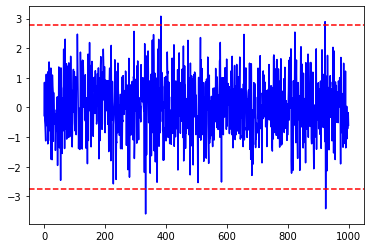



                    <<<<<<<<<<<<<<<<<<<<<<<< Datos_E >>>>>>>>>>>>>>>>>>>>>>>>




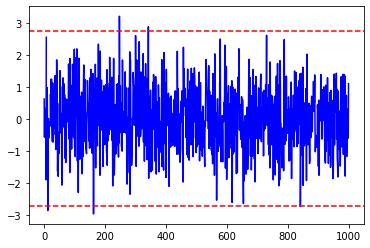



                    <<<<<<<<<<<<<<<<<<<<<<<< Datos_Poisson_1 >>>>>>>>>>>>>>>>>>>>>>>>




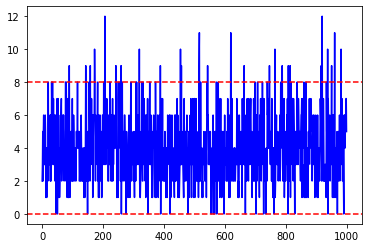



                    <<<<<<<<<<<<<<<<<<<<<<<< Datos_Poisson_3 >>>>>>>>>>>>>>>>>>>>>>>>




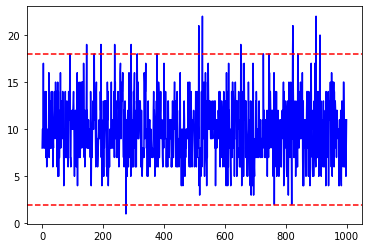



                    <<<<<<<<<<<<<<<<<<<<<<<< Datos_F >>>>>>>>>>>>>>>>>>>>>>>>




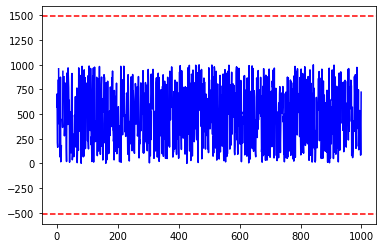



                    <<<<<<<<<<<<<<<<<<<<<<<< Datos_G >>>>>>>>>>>>>>>>>>>>>>>>




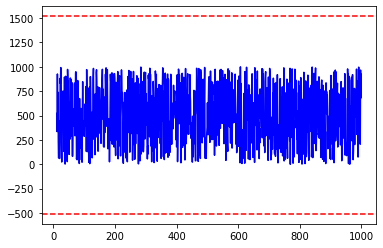



                    <<<<<<<<<<<<<<<<<<<<<<<< Datos_cate_C >>>>>>>>>>>>>>>>>>>>>>>>




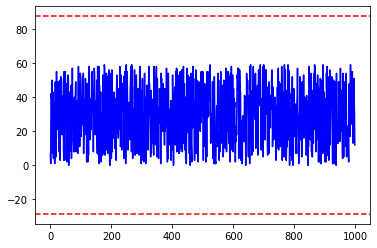


- Se han inputado 4 nulos a la variable Datos_D (tenía porcentaje de nulos de: 0.004) 


- Se han inputado 9 nulos a la variable Datos_E (tenía porcentaje de nulos de: 0.009) 


- Se han inputado 27 nulos a la variable Datos_Poisson_1 (tenía porcentaje de nulos de: 0.027) 


- Se han inputado 11 nulos a la variable Datos_Poisson_3 (tenía porcentaje de nulos de: 0.011) 


- Se han inputado 7 nulos a la variable Datos_F (tenía porcentaje de nulos de: 0.007) 


- Se han inputado 11 nulos a la variable Datos_G (tenía porcentaje de nulos de: 0.011) 



In [197]:
ejemplo.remove_outliers()

In [198]:
# ejemplo.df.isna().sum()
# ejemplo[['Datos_D','Datos_E','Datos_F']].isna().any()
ejemplo[['Datos_D','Datos_E','Datos_F']].isna().any()

Datos_D    False
Datos_E    False
Datos_F    False
dtype: bool

# Modelos



                    <<<<<<<<<<<<<<<<<<<<<<<< Datos_D >>>>>>>>>>>>>>>>>>>>>>>>




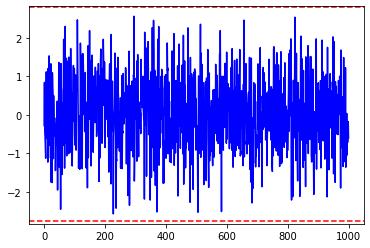



                    <<<<<<<<<<<<<<<<<<<<<<<< Datos_E >>>>>>>>>>>>>>>>>>>>>>>>




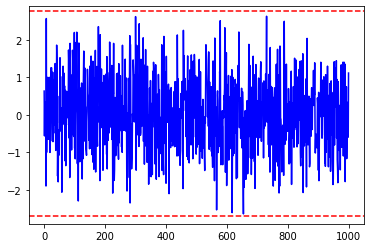



                    <<<<<<<<<<<<<<<<<<<<<<<< Datos_Poisson_1 >>>>>>>>>>>>>>>>>>>>>>>>




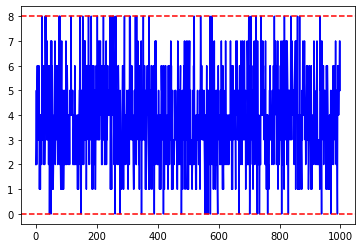



                    <<<<<<<<<<<<<<<<<<<<<<<< Datos_Poisson_3 >>>>>>>>>>>>>>>>>>>>>>>>




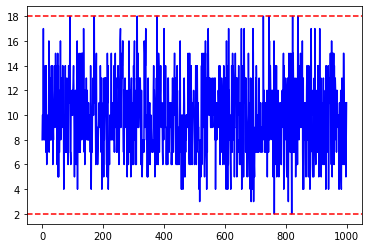



                    <<<<<<<<<<<<<<<<<<<<<<<< Datos_F >>>>>>>>>>>>>>>>>>>>>>>>




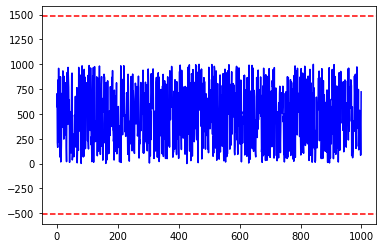



                    <<<<<<<<<<<<<<<<<<<<<<<< Datos_G >>>>>>>>>>>>>>>>>>>>>>>>




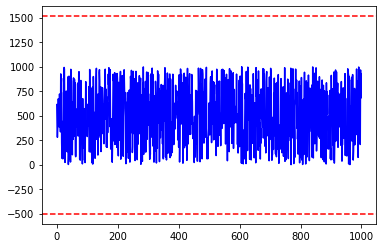



                    <<<<<<<<<<<<<<<<<<<<<<<< Datos_cate_C >>>>>>>>>>>>>>>>>>>>>>>>




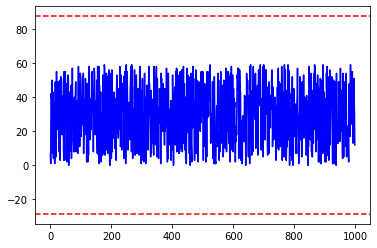

Datos_D: [17.92741492 -5.83312536 -0.06664871]
- RMSE: 291
- R2: 0.0080

 - RESUMEN 

                            OLS Regression Results                            
Dep. Variable:                Datos_G   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     2.672
Date:                Wed, 15 Feb 2023   Prob (F-statistic):             0.0463
Time:                        14:54:55   Log-Likelihood:                -7091.6
No. Observations:                1000   AIC:                         1.419e+04
Df Residuals:                     996   BIC:                         1.421e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

In [199]:

# hay que poner la variavle ejemplo.porcentaje_nulos_permitido=0 porque si hay nulos no coge la función

predictores=['Datos_D','Datos_E','Datos_F']
OUTCOME=['Datos_G']

ejemplo.reg_lineal(predictores,OUTCOME)
# #No funciona con NA ni con distinta longitud dentro de los DF

# ej_lm=LinearRegression()
# ej_lm.fit(df_prueba[predictores],df_prueba[OUTCOME])

# for name, coef in zip(predictores,ej_lm.coef_):
#     print(f"{name}: {coef}")

# fitted= ej_lm.predict(df_prueba[predictores])
# RMSE= np.sqrt(mean_squared_error(df_prueba[OUTCOME],fitted))
# r2= r2_score(df_prueba[OUTCOME],fitted) 

# # RMSE es como el accuracy del modelo (es practicamente igual al RSE)
# print(f"- RMSE: {RMSE:.0f}")

# # coeficiente de determinación:  0-1 proporción de varianza en los datos
# # que estan contabilizados en el modelo
# print(f"- R2: {r2:.4f}")


# model=sm.OLS(df_prueba[OUTCOME],df_prueba[predictores].assign(const=1) )
# resul=model.fit()
# resul.summary()

In [200]:
ejemplo[predictores].isna().any()

Datos_D    False
Datos_E    False
Datos_F    False
dtype: bool

In [201]:
ejemplo.df_inputado

pandas.core.frame.DataFrame

In [202]:
ejemplo.train_regresion()

# y=df_prueba[OUTCOME]
# d=pd.get_dummies(df_prueba[predictores],drop_first=True)

# # var es un df de las vars
# def train_model(var):
#     if len(var)==0:
#         return None
#     model= LinearRegression()
#     model.fit(d[var],y)
#     return model 

# def score_model(model,var):
#     if (len(var)==0):
#         return( AIC_score(y, [y.mean()]*len(y), model, df=1))
#     return(AIC_score(y,model.predict(d[var]), model) )

# best_model, best_var= stepwise_selection(d.columns, train_model, score_model, verbose=True)


# print(f"Intercept: {best_model.intercept_:.3f}")
# print(f"Coeficients:")
# for name, coef in zip(best_var,best_model.coef_):
#     print(f"{name}: {coef}")

Ha habido un problema, seguramente sea por el DF


In [203]:
weights=pd.DataFrame
ejemplo.weighted_regression( weights)
# Weight regrassion
#  - diferentes observaciones medidas con precisiones diferentes
#  - Filas representas distintos casos

# def weighted_regression(df, outcome, predictors, weights):
#     X = df[predictors].values
#     y = df[outcome].values
#     w = df[weights].values

#     model = LinearRegression()
#     model.fit(X, y, sample_weight=w)

#     return model
 

TypeError: float() argument must be a string or a real number, not 'property'

In [ ]:
# si tienes variables con muchas categorias pues 
# tendrías un monton de dummys y no es la cosa tampoco 
# que va a parecer esto un sudoku (es que además pueden incluso ser practicamente iguales)
# Entonces los puedes codificar usando los residuos de la regresión

grupos1 = pd.DataFrame([
    *pd.DataFrame ({
    'Datos_cate_C': df_prueba['Datos_cate_C'],
    'residuos':df_prueba[OUTCOME]-ej_lm.predict(df_prueba[predictores])
    }).groupby(['Datos_cate_C']).apply(lambda x:
       {
    'Datos_cate_C' : x.iloc[0,0],
    'count': len(x),
    'residuo_medio': x.residuos.median()
       })
]).sort_values( 'residuo_medio')

grupos1['cum_count']=np.cumsum(grupos1['count'])
grupos1['Col_a_codificar_grupos']=pd.qcut(grupos1['cum_count'],5,labels=False,retbins=False)
to_join= grupos1[['Datos_cate_C','Col_a_codificar_grupos']].set_index('Datos_cate_C')

df_prueba=df_prueba.join(to_join, on='Datos_cate_C')
df_prueba[['Datos_cate_C','Col_a_codificar_grupos']]
# grupos4=grupos3.sort_values( 'residuo_medio')

In [ ]:
# interacciones entre variables que entre ellas hacen efecto en el outcome
import statsmodels.formula.api as smf

model=smf.ols(formula= "Datos_G ~Datos_D*Col_a_codificar_grupos+Datos_E+Datos_F",data=df_prueba )
results=model.fit()
results.summary()

In [ ]:


# Outliers no es lo mismo que en la distribución porque aqui se usa el 

# cojo una categoria 
datos_cateC_1=df_prueba.loc[df_prueba["Datos_cate_C"]==1,]
datos_cateC_1=df_prueba.loc[df_prueba["Datos_cate_C"]==1,]
ej_outliers=sm.OLS(datos_cateC_1[OUTCOME], datos_cateC_1[predictores].assign(conts=1))
resul_1=ej_outliers.fit()

influence=OLSInfluence(resul_1)
sresiduals= influence.resid_studentized_internal

outliers=datos_cateC_1.loc[sresiduals.idxmin(), :]
print("resultado", outliers[OUTCOME])
print(outliers[predictores])

In [ ]:
# 
influecnia= OLSInfluence(resul_1)
fig, ax=plt.subplots(figsize=(5,5))
ax.axhline(-2.5, linestyle='--', color='C1')
ax.axhline(2.5, linestyle='--', color='C1')
ax.scatter(influence.hat_matrix_diag, 
           influence.resid_studentized_internal,
           s=1000*np.sqrt(influence.cooks_distance[0]), 
           alpha=0.5)
plt.show()

In [ ]:
fig, ax=plt.subplots(figsize=(5,5))
# sns.regplot(resul_1.fittedvalues,
#             np.abs(resul_1.resid),
#             scatter_kws={'alpha':0.25}, 
#             line_kws={'color': 'C1'},
#             lowess=True,
#             ax=ax)


df = pd.DataFrame({'fitted': resul_1.fittedvalues, 
                   'residuals': np.abs(resul_1.resid)})
sns.regplot(x='fitted', y='residuals', data=df, scatter_kws={'alpha':0.25}, line_kws={'color': 'C1'}, lowess=True, ax=ax)
ax.set_xlabel('predictos')
ax.set_ylabel('abs(residuos)')
plt.show()

In [ ]:
# residuos parciales 

# La función sm.graphics.plot_ccpr de la biblioteca statsmodels es una función para 
# crear un gráfico de la influencia residual del modelo lineal. 
# La función toma como argumentos un objeto de resultado de modelo lineal (resul_1) 
# y un nombre de variable independiente ('Datos_F').

# El gráfico de influencia residual se utiliza para evaluar la influencia de cada 
# punto en el ajuste del modelo lineal. En la gráfica, los ejes representan las 
# predicciones del modelo y los residuales absolutos respectivamente. 
# Los puntos son una representación de cada observación en el conjunto de datos, 
# con la posición de cada punto indicando la influencia de esa observación en el modelo.

# El gráfico de influencia residual se utiliza para detectar outliers y puntos 
# con influencia anormal en el modelo lineal. Si un punto tiene una influencia 
# anormal en el modelo, puede ser necesario revisar ese punto en el conjunto de datos 
# y considerar si debería ser incluido o excluido del modelo.

# En general, un gráfico de influencia residual es una herramienta útil para 
# comprender la calidad del ajuste del modelo lineal y para detectar posibles 
# problemas en los datos o en el modelo.

sm.graphics.plot_ccpr(resul_1,'Datos_F')